# Formula 1 Data Exploration
## by Piotr Majorkowski

## Preliminary Wrangling

This document explores a dataset containing Formula 1 race results from 1950 to 2018.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# load datasets
df_results = pd.read_csv('results.csv', names = ['result_id', 'race_id', 'driver_id', 'constructor_id', 'number', 'grid', 'position','position_text','position_order', 'points', 'laps','time','milliseconds','fastest_lap','rank','fastest_lap_time','fastest_lap_speed','status_id'], header = None)
df_races = pd.read_csv('races.csv', names = ['race_id', 'year', 'round','circuit_id', 'name','date','time','url'],header=None)
df_drivers = pd.read_csv('driver.csv', names = ['driver_id','driver_ref','number','code','forename','surname','dob','nationality','url'], header = None)
df_constructors = pd.read_csv('constructors.csv', names = ['constructor_id','constructor_ref','name','nationality','url'], header=None)

In [3]:
# merge datasets into a master data frame
df = pd.merge(df_results,df_races[['race_id','year', 'name','round']],on='race_id', how='left')
df = pd.merge(df,df_drivers[['driver_id','driver_ref', 'nationality']],on='driver_id', how='left')
df = pd.merge(df,df_constructors[['constructor_id', 'name','nationality']],on='constructor_id', how='left')

**Data Cleaning**

In [4]:
# drop unnecessary columns
df.drop(['number','position','position_text','laps','fastest_lap','status_id', 'result_id','race_id','driver_id','constructor_id'], axis=1, inplace=True)

# rename columns
df.rename(columns={'rank': 'fastest_lap_rank', 'name_x': 'gp_name', 'nationality_x': 'driver_nationality', 'name_y': 'constructor_name', 'nationality_y': 'constructor_nationality', 'driver_ref': 'driver'}, inplace=True)

# rearrange columns
df = df[['year', 'gp_name', 'round', 'driver', 'constructor_name','grid','position_order','points','time','milliseconds','fastest_lap_rank','fastest_lap_time','fastest_lap_speed','driver_nationality','constructor_nationality']]

# drop season 2019 because it is incomplete
df = df[df['year'] != 2019]

# sort values
df = df.sort_values(by=['year', 'round','position_order'], ascending = [False, True, True])

# replace '\N' values in time columns with NaN because time was not registered when a driver did not finish a race
# or was lapped by another driver
df.time.replace('\\N', np.nan, inplace=True)
df.milliseconds.replace('\\N', np.nan, inplace=True)
df.fastest_lap_rank.replace('\\N', np.nan, inplace=True)
df.fastest_lap_time.replace('\\N', np.nan, inplace=True)
df.fastest_lap_speed.replace('\\N', np.nan, inplace=True)

# change datatypes
df.fastest_lap_speed = df.fastest_lap_speed.astype(float)
df.fastest_lap_rank = df.fastest_lap_rank.astype(float) # I cannot convert to int because there are missing values (as expected)
df.milliseconds = df.milliseconds.astype(float)

# resent index
df.reset_index(drop = True, inplace=True)

In [5]:
# high-level overview of data shape and composition
print(df.shape)
print(df.info())
print(df.head(5))

(24197, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24197 entries, 0 to 24196
Data columns (total 15 columns):
year                       24197 non-null int64
gp_name                    24197 non-null object
round                      24197 non-null int64
driver                     24197 non-null object
constructor_name           24197 non-null object
grid                       24197 non-null int64
position_order             24197 non-null int64
points                     24197 non-null float64
time                       6205 non-null object
milliseconds               6204 non-null float64
fastest_lap_rank           5951 non-null float64
fastest_lap_time           5782 non-null object
fastest_lap_speed          5782 non-null float64
driver_nationality         24197 non-null object
constructor_nationality    24197 non-null object
dtypes: float64(4), int64(4), object(7)
memory usage: 2.8+ MB
None
   year                gp_name  round     driver constructor_name  grid  \
0  2018

### What is the structure of your dataset?
This dataset contains data from 1950 (the inaugural season) all the way through the 2018 season, and consists of data describing race results, drivers, constructors, and lap times. There are 24197 data points and 15 columns. Data Explanation:
* **year:** the season that the Grand Prix took place.
* **gp_name:** the name of the Grand Prix.
* **round:** the number of the race in each season (e.g. 1 means it's the first race of the season).
* **driver:** the name of the driver. Some drivers have the same surnames, in that case, the second occurance is shown as firstname_lastname (e.g. verstappen and max_verstappen).
* **constructor_name:** the name of the car constructor.
* **grid:** the starting position before the race (depends on the qualifications which occur one day before the race).
* **position_order:** the final position at the end of the race.
* **points:** number of points scored in the race.
* **time:** the amount of time that took to finish the race. Only the winner's time is displayed and driver's behind the winner are shown how far behind the winner they were. If a driver did not finish the race or was lapped by another driver, the value is null.
* **milliseconds:** the amount of time that took to finish the race in milliseconds. If a driver did not finish the race or was lapped by another driver, the value is null.
* **fastest_lap_rank:** the order of the fastest lap during a race.
* **fastest_lap_time:** the shortest amount of time that took to complete a lap in the race.
* **fastest_lap_speed:** average speed on the fastest lap.
* **driver_nationality:** driver's nationality.
* **constructor_nationality:** country where the car constructor is based.


### What is/are the main feature(s) of interest in your dataset?

I'm most interested in figuring out how Formula 1 changed over time. I will look into:

1. What drivers and constructors were the most successfull throughout the history of the sport?
2. How grid position affect the finish position?
3. Did the average speed of the cars change? Is the trend similar on all tracks?
4. Do certain teams perform better on fast tracks vs. technical tracks?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

The most important features in my investigation will be the amount GP wins, grid, finish place, and fastest lap speed.

## Univariate Exploration

I will start by looking at the total amount of GP wins distribution.

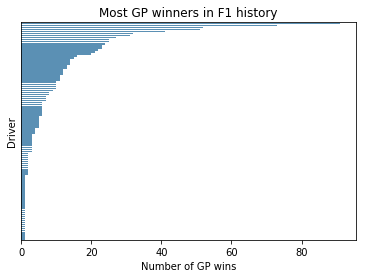

In [6]:
# create new dataframe of all GP winners
data_driver_all = df.loc[df['position_order'] == 1].groupby('driver')['position_order'].count().sort_values(ascending=False).to_frame().reset_index()

# change color
base_color = sb.color_palette()[0]

#create barplot
sb.barplot(data = data_driver_all, y = 'driver', x = 'position_order', color = base_color, alpha = 0.8)
plt.title('Most GP winners in F1 history')
plt.ylabel('Driver')
plt.xlabel('Number of GP wins')
plt.yticks([]);

The barplot shows that there is a large distribution in GP wins. There are only a few drivers in history who won over 20 GPs in their careers. Most drivers who ever won a GP, came first in a race only 1 - 2 times. On the other hand, we see that there are some drivers who completely dominated F1 racing and won over 50 GPs in their careers. I'm going to zoom in to see the top 10 drivers in the history of the sport.

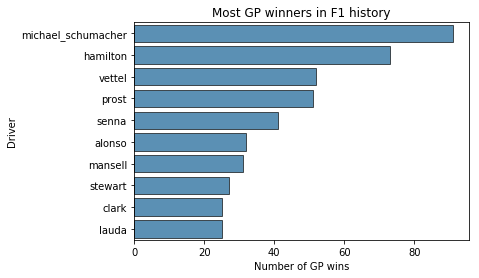

In [7]:
# create new dataframe of top 10 GP winners
data_top10 = data_driver_all.head(10)

#create barplot
sb.barplot(data = data_top10, y = 'driver', x = 'position_order', color = base_color,
           alpha = 0.8, linewidth=.8, edgecolor="black")
plt.title('Most GP winners in F1 history')
plt.ylabel('Driver')
plt.xlabel('Number of GP wins');

In [8]:
print(data_top10)

               driver  position_order
0  michael_schumacher              91
1            hamilton              73
2              vettel              52
3               prost              51
4               senna              41
5              alonso              32
6             mansell              31
7             stewart              27
8               clark              25
9               lauda              25


These are the best drivers in history of Formula 1 in terms of the total GP wins. The most successful driver is Michael Schumacher with 91 wins. Lewis Hamilton and Sebastian Vettel won 73 and 52 GPs respectively. These two drivers are the only drivers on the list that are not retired; therefore, they could potential stop Schumacher's domination.

Next, I'm going to look into how successful are different car constructors.

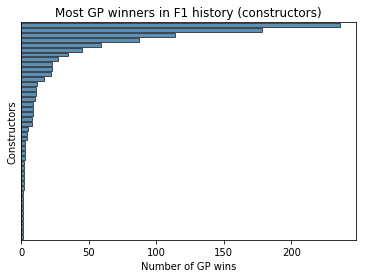

In [9]:
# create new dataframe of all GP constructor winners
data_cons_all = df.loc[df['position_order'] == 1].groupby('constructor_name')['position_order'].count().sort_values(ascending=False).to_frame().reset_index()

#create barplot
sb.barplot(data = data_cons_all, y = 'constructor_name', x = 'position_order',
           color = base_color, alpha = 0.8, linewidth=.8, edgecolor="black")
plt.title('Most GP winners in F1 history (constructors)')
plt.ylabel('Constructors')
plt.xlabel('Number of GP wins')
plt.yticks([]);

We can see a similar pattern in the constructors' chart. There are a few teams that completely dominate the sports, while most teams won only a handful of GPs in their history. I will zoom in to see the top 10 car manufacturers in the F1 history.

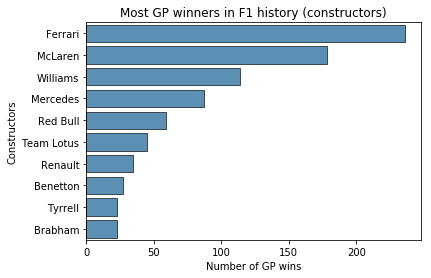

In [10]:
# create new dataframe of top 10 GP constructors winners
data_top10cons = data_cons_all.head(10)

#create barplot
sb.barplot(data = data_top10cons, y = 'constructor_name', x = 'position_order',
           color = base_color , alpha = 0.8, linewidth=.8, edgecolor="black")
plt.title('Most GP winners in F1 history (constructors)')
plt.ylabel('Constructors')
plt.xlabel('Number of GP wins');

In [11]:
print(data_top10cons)

  constructor_name  position_order
0          Ferrari             236
1          McLaren             178
2         Williams             114
3         Mercedes              87
4         Red Bull              59
5       Team Lotus              45
6          Renault              35
7         Benetton              27
8          Tyrrell              23
9          Brabham              23


The most successful team is Ferrari from Italy with 236 GP wins. Next, we have McLaren with 178 wins and Williams with 114 victories. Both of these teams are from the UK.

The distibution was large in both driver and constructor dataset. There were few drivers/constructor who won GPs many times, while most individuals came first only a handful of times. After zooming in on top 10 results, I could see how far ahead the top competitors are.

## Bivariate Exploration

In this section, I will investigate the relationship between starting and finish position. In addition, I will look into how speed changed over time at different tracks.

C:\Users\Piotr Majorkowski\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


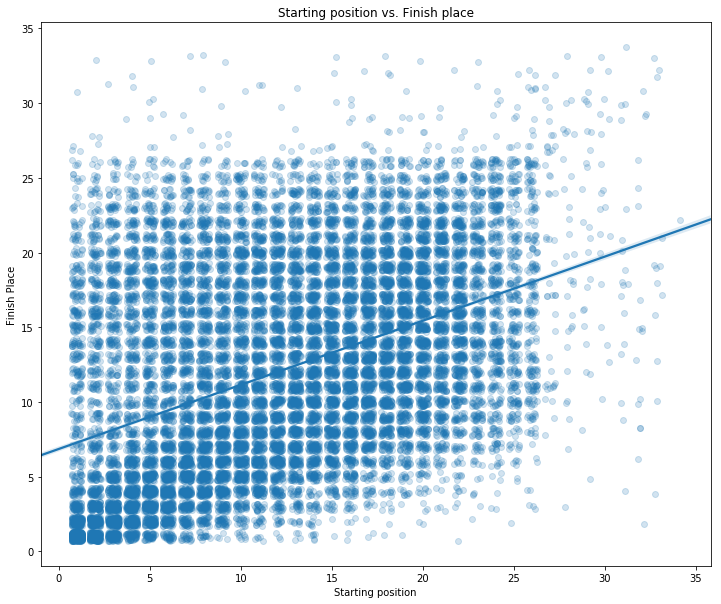

In [12]:
# I will exclude data points where grid = 0 because it skews the data. 0 means that the driver started from pit lane.
df_no_zero = df[df['grid'] != 0]

# create a plot
plt.figure(figsize = [12, 10])
sb.regplot(data = df_no_zero, x = 'grid', y = 'position_order', x_jitter = 0.3, y_jitter = 0.3, scatter_kws = {'alpha' : 1/5});
plt.title('Starting position vs. Finish place')
plt.ylabel('Finish Place')
plt.xlabel('Starting position');

On this chart, we can see a linear relationship between the starting and finish position, which is what was expected. We can also see that most races had up to 25 drivers, while some of them even had over 30 drivers.

Next, I will investigate whether the speed of the cars changed over the years. Because this data is only available from season 2004 onwards, I will only be looking at these years.

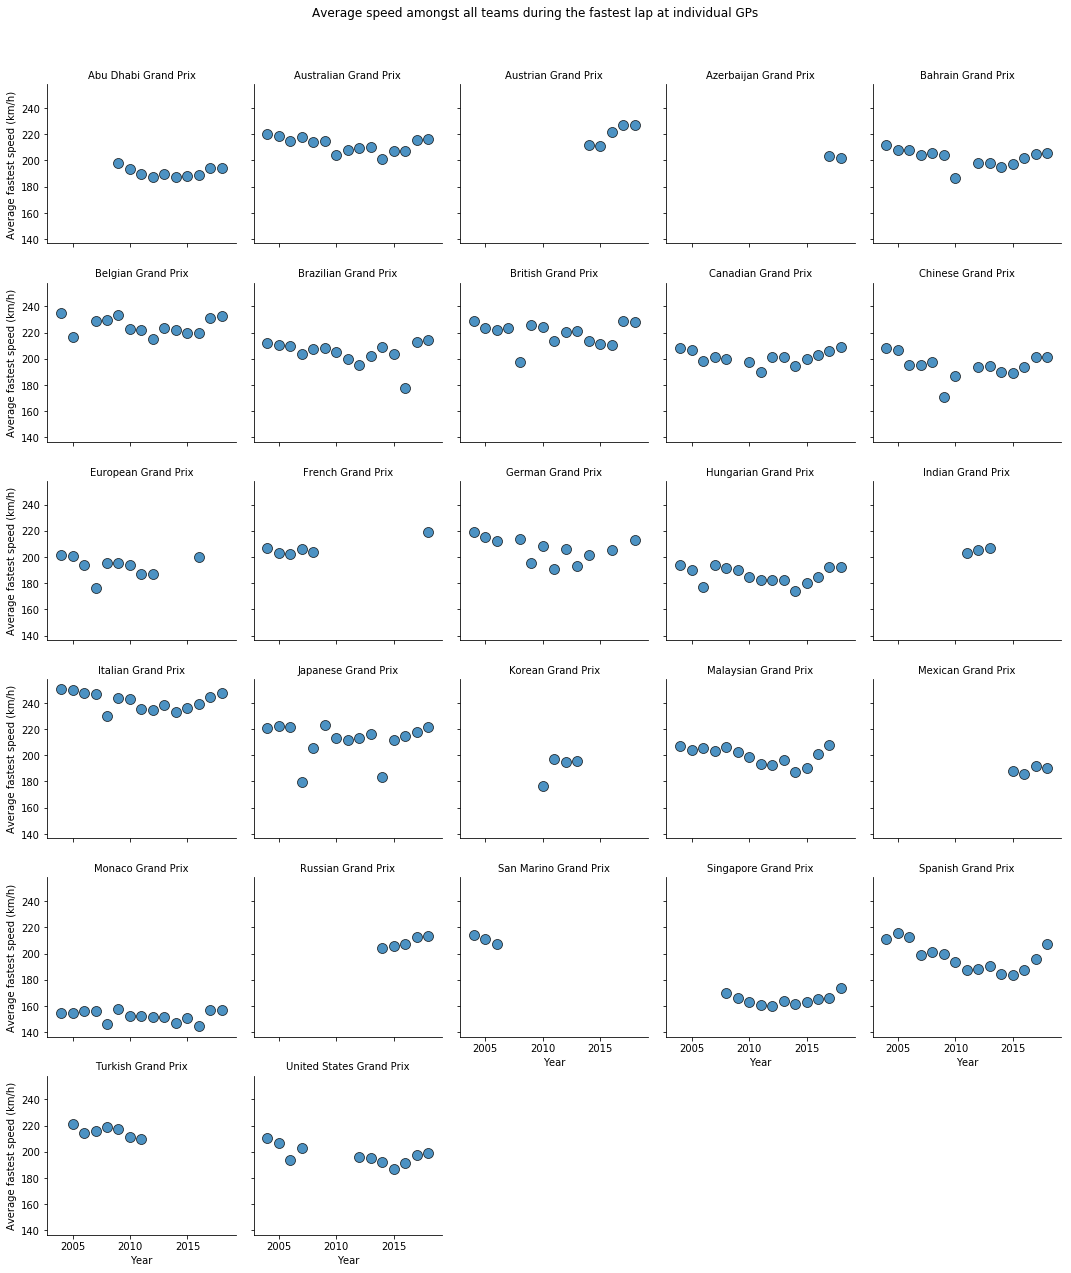

In [13]:
# create new data frame for seasons 2004 onwards
df_speed = df[df['year'] >= 2004]
df_group_speed = df_speed.groupby(['gp_name', 'year'])['fastest_lap_speed'].mean().to_frame().reset_index()

# create a facetgrid
g = sb.FacetGrid(data = df_group_speed, col = 'gp_name',
                col_wrap=5)
g.map(plt.scatter, 'year','fastest_lap_speed', alpha = 0.8, linewidth=.8, edgecolor="black", s = 100 )
g.set_titles("{col_name}")
g.set_xlabels('Year')
g.set_ylabels('Average fastest speed (km/h)')
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Average speed amongst all teams during the fastest lap at individual GPs');

In general, we see a decrease in the average fastest lap from year 2004 to 2015 for allmost all circuits. From 2015 onwards, the speed started to come back again to the values from 2004. 

Some GPs have sudden changes in the average fastest lap due to changes to a different location (e.g. in 2007 and 2008, Japan Fuji Speedway replaced Japan Suzuka (https://en.wikipedia.org/wiki/Japanese_Grand_Prix )) or modifications to the track (*The 2007 season saw the first of the two final sweepers replaced with a slow chicane in an effort to improve overtaking* (https://en.wikipedia.org/wiki/Circuit_de_Barcelona-Catalunya )).

We can also see that the speed is very different on each track. For instnance, the Italian GP is the fastest race in the calendar with average speed exceeding 240 km/h. On the other hand, Monaco is the slowest race with average speed below 160 km/h. This was expected, as Monaco GP takes place on the narrow streets of a city.

## Multivariate Exploration

In this section I will analyze the difference in speeds by teams in Mozna (Italian GP) and Monaco. I will try to see if some teams are better than others on different tracks.

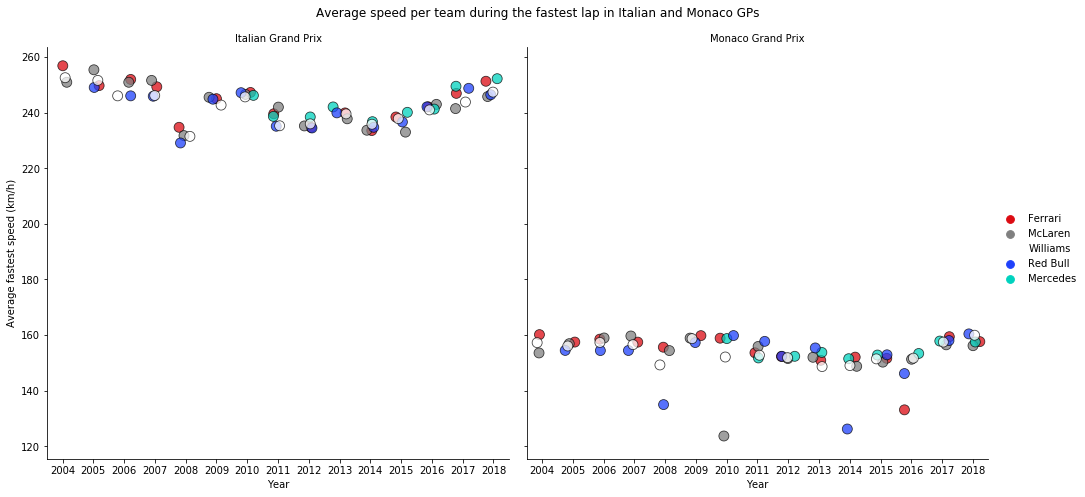

In [14]:
# create new data frame for Monaco and Italian GPs after 2003 with the most popular teams.
df_it_mon = df[(df['year'] >= 2004) 
               & ((df['constructor_name'] == 'McLaren') | (df['constructor_name'] == 'Williams')
               | (df['constructor_name'] == 'Ferrari') | (df['constructor_name'] == 'Red Bull')
               | (df['constructor_name'] == 'Mercedes'))
               & ((df['gp_name'] == 'Monaco Grand Prix') | (df['gp_name'] == 'Italian Grand Prix'))]
df_speed_constructor = df_it_mon.groupby(['gp_name', 'year','constructor_name'])['fastest_lap_speed'].mean().to_frame().reset_index()

# assign colors to the teams
my_pal = {"Ferrari": "#dc0b12", "McLaren": "#808080", "Williams":"#FFFFFF","Red Bull":"#1f41fb","Mercedes":"#00d2be"}

# create a facetgrid
g = sb.FacetGrid(data = df_speed_constructor, col = 'gp_name', height = 7)
g.map(sb.stripplot, 'year', 'fastest_lap_speed',
      hue = df_speed_constructor['constructor_name'],
      alpha = 3/4, jitter = 0.25, s = 10, linewidth=.8, edgecolor="black", order = None, palette=my_pal)
g.set_titles("{col_name}")
g.set_xlabels('Year')
g.set_ylabels('Average fastest speed (km/h)')
g.add_legend()
plt.subplots_adjust(top=0.90)
g.fig.suptitle('Average speed per team during the fastest lap in Italian and Monaco GPs');

Overall, I didn't notice a lot of difference in performace on different tracks by major teams. Seems like, if a car is fast in a high-speed race like Italy, then it should also be fast on a more technical track, like Monaco. For example, McLaren was one of the fastest cars in both Italy and Monaco from 2005 to 2011. On the other hand, Red Bull which completely dominated the sport in seasons 2010 - 2013 (https://en.wikipedia.org/wiki/Red_Bull_Racing), was not very fast in Italy in these years; however, in highly technical Monaco, it was the fastest car on track.

One reason that can explain this, is the fact that certain drivers prefer one track over the other; hence, they perform better on their favorite tracks. Another reason can be the fact that these two GPs are a few months apart from each other; therefore, engineers have a lot of time to improve the cars between the races.

I noticed that Monaco GP has some oddly slow lap speeds which are not present in Italy. I suspect that these are caused by the drivers who did not finish the race due to accidents. This makes sense because the Monaco track has a very small marging of error; therefore, drivers are more likely to crash and not finish the race than in races where the track is wider, like Italy.